<a href="https://colab.research.google.com/github/eskndirg/Block-segmentation-and-distress-detection/blob/main/unet_model_Block_Distress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob
from tensorflow.keras.callbacks import TensorBoard


In [ ]:
image_directory = '/content/drive/MyDrive/segmentation/Block Distress/Image'
mask_directory = '//content/drive/MyDrive/segmentation/Block Distress/Resized_Binary'

In [ ]:
SIZE = 512
num_images = 220

Load images and masks in order so they match

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/segmentation/Block Distress/Image/*.PNG")
image_names.sort()
image_names_subset = image_names[0:num_images]
#images = [cv2.imread(img,0) for img in image_names_subset]
images = []
for img in image_names_subset:
    img = cv2.imread(img, 0)
    img_resized = cv2.resize(img, (256, 256))  # Resize the image to 256x256
    images.append(img_resized)
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)
print(image_names)
len(image_names)

Reading mask

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/segmentation/Block Distress/Resized_Binary/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (220, 256, 256, 1)
Mask data shape is:  (220, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

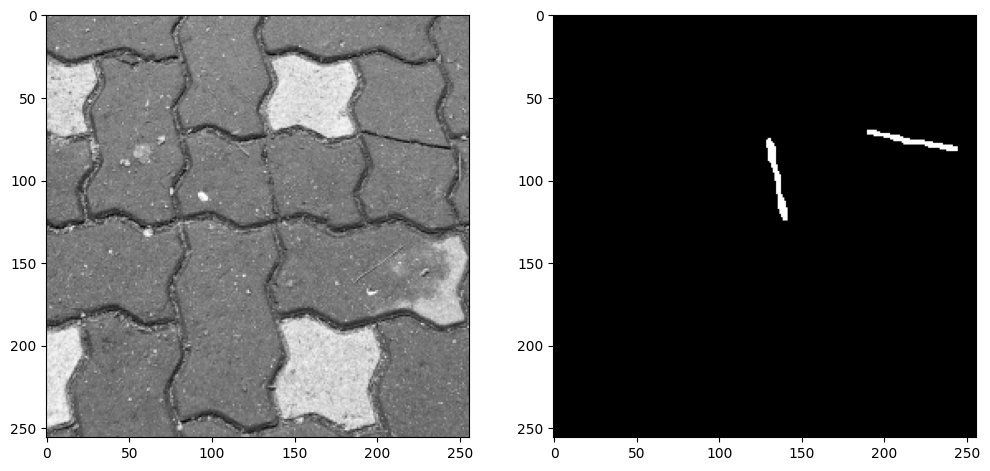

In [ ]:
# Check, view few images
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model =build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate=0.00001),loss='binary_crossentropy',metrics =['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 256, 256, 64  256        ['conv2d_57[0][0]']              
 ormalization)                  )                                                     

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 8,
                    verbose=1,
                    epochs=100,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[tensorboard_callback])


Epoch 1/100
18/18 [==============================] - 38s 558ms/step - loss: 0.5191 - accuracy: 0.7758 - val_loss: 0.6946 - val_accuracy: 0.3590
Epoch 2/100
18/18 [==============================] - 10s 571ms/step - loss: 0.4820 - accuracy: 0.8446 - val_loss: 0.6842 - val_accuracy: 0.9410
Epoch 3/100
18/18 [==============================] - 10s 556ms/step - loss: 0.4599 - accuracy: 0.8721 - val_loss: 0.6691 - val_accuracy: 0.9767
Epoch 4/100
18/18 [==============================] - 11s 587ms/step - loss: 0.4410 - accuracy: 0.8934 - val_loss: 0.6475 - val_accuracy: 0.9801
Epoch 5/100
18/18 [==============================] - 10s 576ms/step - loss: 0.4235 - accuracy: 0.9125 - val_loss: 0.6175 - val_accuracy: 0.9814
Epoch 6/100
18/18 [==============================] - 10s 569ms/step - loss: 0.4070 - accuracy: 0.9283 - val_loss: 0.5780 - val_accuracy: 0.9830
Epoch 7/100
18/18 [==============================] - 10s 540ms/step - loss: 0.3884 - accuracy: 0.9431 - val_loss: 0.5358 - val_accuracy:

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/unet_model/Block_Distress_unet_model_220_image_150_epochs_v2.hdf5')

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5
# y_pred_thresholded.shape
# y_test.shape

In [ ]:
from tensorflow.keras.metrics import MeanIoU

In [ ]:
#IOU for each class is..
# IOU = true_positive / (true_positive + false_positive + false_negative).
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test,y_pred_thresholded)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[0,1])
precision = values[1,1]/(values[1,1] + values[0,1])
Recall = values[1,1]/(values[1,1] + values[1,0])
F1_score = 2 /((1/precision) + (1/Recall))
print("Crack_class Mean_IoU =", class2_IoU*100)
print("Non crack_class Mean_IoU =", class1_IoU*100)
print("Precision =", precision *100)
print("Recall =", Recall*100)
print("F1-score =", F1_score*100)

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 15))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


# values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
# print(values)


